# 1. Information about the submission

## 1.1 Name and number of the assignment

**Text categorization: argument mining. Assignment 2**.

## 1.2 Student name

**Nikolay Kalmykov**

## 1.3 Codalab user ID

**Nick**

## 1.4 Additional comments

**I would like to load my solution on codalab, April 24. But, the platform didn't answer.**

# 2. Technical Report

I used wandb to display my logs - https://wandb.ai/nickcalmykow281/Argument%20Mining?workspace=user-nickcalmykow281

## 2.1 Methodology

I will use `DeepPavlov/rubert-base-cased` model (12-layer, 768-hidden, 12-heads, 180M parameters), that was trained on the Russian part of Wikipedia and news data.

During EDA, it was noticed that we are faced with the task of classifying imbalanced classes (many labels from an irrelevant class).

Therefore, a **two-stage classification** was used to solve the problem:

1) On the first stage, we classify the relevant (**0,1,2**) and irrelevant (**-1**) classes. For this, we use `find_near_matches` from `fuzzysearch` and search the target word in sentence ("vaccine", "quarantine", "mask", etc.). If the sentence contains this word, then it will be relevant. Surprisingly, this gave a good result on the train.

2) On the second stage, we do the classification between relevant classes. The algorithm is the next:

* In preprocessing part, I removed the word `[USER]`.

* Calculated the class weights for a three-class classification problem based on the frequency of each class in the training data.

* I used the prompt as part of the input sequence, because the model may be able to better understand the context of the text and make more accurate predictions `What does the author think about the topic «{topic[CLASS_NAME]}»? [SEP] + Sentence `.

* Then, I used the next hyperparameters and two linear BERT heads:
  
  * batch_size = 8
  * num_epoch = 10
  * learning_rate = 4e-5

## 2.2 Discussion of results


Method | F1 Stance Detection | F1 Premise Classification
--- | --- | --- |
Baseline | 0.4180 | 0.4355
DeepPavlov/rubert-base-cased | 0.5438 | 0.6109
Machine Translation (Eng) + digitalepidemiologylab/covid-twitter-bert | 0.3737 | 0.4089
***Machine Translation (Eng) + bert-base-uncased*** | 0.5639 | 0.6219
Machine Translation (Eng) + bert-large-uncased | 0.4897 |  0.4898
Machine Translation (Eng) + lordtt13/COVID-SciBERT | 0.5469 |  0.6250

The best metric was obtained using Machine Translation and the model **bert-base-uncased**, then **lordtt13/COVID-SciBERT**.

From the results, you can see that Machine Translation provided insignificant improvement in the metric.

Also, I tried the models **COVID-tune BERT** (https://huggingface.co/digitalepidemiologylab/covid-twitter-bert), **bert-large-uncased** (https://huggingface.co/bert-large-uncased) using Machine Translation. But, I  didn't get the good results.

I think, the easiest way to get a good score is to implement 6 models. But, this way is appropriate for competition, not for real life. Since it is computationally intensive.

Moreover, in this paper are described the best solutions - https://www.dialog-21.ru/media/5745/alibaevakplusloukachevitchn115.pdf.

# 3. Code

## 3.1 Requirements

In [ ]:
# !pip install transformers
# !pip install torchmetrics
# !pip install wandb
# !pip install fuzzysearch
# !pip install sentencepiece

In [ ]:
import wandb
import torch
import time
import datetime
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from fuzzysearch import find_near_matches

## 3.2 Download the Data

In [ ]:
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/test-no_labels.tsv
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/train.tsv

--2023-04-26 23:33:38--  https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/test-no_labels.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298180 (291K) [text/plain]
Saving to: ‘test-no_labels.tsv’

test-no_labels.tsv  100%[===================>] 291.19K  --.-KB/s    in 0.03s   

2023-04-26 23:33:38 (8.56 MB/s) - ‘test-no_labels.tsv’ saved [298180/298180]

--2023-04-26 23:33:38--  https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15

## 3.3 Machine Translation for test-no_labels (comment it after the first run)

In [ ]:
# test_df = pd.read_csv('test-no_labels.tsv', sep='\t')

# tokenizer_transl = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
# model_transl = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en')

# english_sentences = []

# russian_sentences = test_df["text"].tolist()

# word_to_remove_1 = "[USER] "
# word_to_remove_2 = "[USER], "

# for i, sentence in enumerate(russian_sentences):
#     print(i)
#     # Clean up the sentence by removing URLs and usernames
#     cleaned_sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)

#     # Translate the cleaned sentence from Russian to English
#     inputs = tokenizer_transl(cleaned_sentence, return_tensors='pt', padding=True)
#     outputs = model_transl.generate(**inputs)
#     translated_sentence = tokenizer_transl.decode(outputs[0], skip_special_tokens=True)
#     if word_to_remove_1 in translated_sentence:
#         translated_sentence = translated_sentence.replace(word_to_remove_1, "")

#     if word_to_remove_2 in translated_sentence:
#         translated_sentence = translated_sentence.replace(word_to_remove_2, "")

#     english_sentences.append(translated_sentence)

# test_df['text'] = english_sentences

# test_df.to_csv('test-no_labels_English.tsv', sep="\t", index=False)

## 3.4 Machine Translation for train (comment it after the first run)

In [ ]:
# train_df = pd.read_csv('train.tsv', sep='\t')

# tokenizer_transl = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ru-en')
# model_transl = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ru-en')

# english_sentences = []

# russian_sentences = train_df["text"].tolist()

# word_to_remove_1 = "[USER] "
# word_to_remove_2 = "[USER], "

# for i, sentence in enumerate(russian_sentences):
#     print(i)
#     # Clean up the sentence by removing URLs and usernames
#     cleaned_sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)

#     # Translate the cleaned sentence from Russian to English
#     inputs = tokenizer_transl(cleaned_sentence, return_tensors='pt', padding=True)
#     outputs = model_transl.generate(**inputs)
#     translated_sentence = tokenizer_transl.decode(outputs[0], skip_special_tokens=True)
#     if word_to_remove_1 in translated_sentence:
#         translated_sentence = translated_sentence.replace(word_to_remove_1, "")

#     if word_to_remove_2 in translated_sentence:
#         translated_sentence = translated_sentence.replace(word_to_remove_2, "")

#     english_sentences.append(translated_sentence)

# train_df['text'] = english_sentences

# train_df.to_csv('train_English.tsv', sep="\t", index=False)

## 3.5 Relevant and Irrelevant classification for test (comment it after the first run)

In [ ]:
# test_df = pd.read_csv('test-no_labels_English.tsv', sep='\t')
# test_df.head(5)

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument
0,17059,Vacation would only give rise to the spread of...,NaN,NaN,NaN,NaN,NaN,NaN
1,17072,"Thought we'd sit in a little company, talk whi...",NaN,NaN,NaN,NaN,NaN,NaN
2,17077,"in China, the disease has been on its way sinc...",NaN,NaN,NaN,NaN,NaN,NaN
3,17082,If the unimptomably good third of the populati...,NaN,NaN,NaN,NaN,NaN,NaN
4,17089,And training involves a mass accumulation of p...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# for i in range(len(test_df)):
#     if not (find_near_matches("vaccine", test_df["text"][i], max_l_dist=1) or find_near_matches("immunization", test_df["text"][i], max_l_dist=1)
#          or find_near_matches("vaccination", test_df["text"][i], max_l_dist=1) or find_near_matches("satellite", test_df["text"][i], max_l_dist=1)):
#         test_df.loc[i, "vaccines_stance"] = -1
#         test_df.loc[i, "vaccines_argument"] = -1
#     if not (find_near_matches("quarantine", test_df["text"][i], max_l_dist=1) or find_near_matches("lockdown", test_df["text"][i], max_l_dist=1)):
#         test_df.loc[i, "quarantine_stance"] = -1
#         test_df.loc[i, "quarantine_argument"] = -1
#     if not find_near_matches("mask", test_df["text"][i], max_l_dist=1):
#         test_df.loc[i, "masks_stance"] = -1
#         test_df.loc[i, "masks_argument"] = -1

In [ ]:
# test_df.head()

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument
0,17059,Vacation would only give rise to the spread of...,-1.0,-1.0,NaN,NaN,-1.0,-1.0
1,17072,"Thought we'd sit in a little company, talk whi...",-1.0,-1.0,NaN,NaN,-1.0,-1.0
2,17077,"in China, the disease has been on its way sinc...",-1.0,-1.0,NaN,NaN,-1.0,-1.0
3,17082,If the unimptomably good third of the populati...,-1.0,-1.0,NaN,NaN,-1.0,-1.0
4,17089,And training involves a mass accumulation of p...,NaN,NaN,NaN,NaN,-1.0,-1.0


In [ ]:
# test_df.to_csv('result.tsv', sep="\t", index=False)

## 4. The main part

### Configuration


In [ ]:
config = {
    'model_name': 'bert-base-uncased',
    'num_expiriment': '8',
    'max_length': 256,
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'num_epoch': 10,
    'learning_rate': 4e-5,
    'epsilon': 1e-6,
    'warmup_steps': 800,
    'weight_decay': 0.01
}

### Read data and clear data


In [ ]:
# CLASS_NAME = "quarantine"
CLASS_NAME = "vaccines"
# CLASS_NAME = "masks"

In [ ]:
test_df = pd.read_csv('test-no_labels_English.tsv', sep='\t')
test_df.head(5)

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument
0,17059,Vacation would only give rise to the spread of...,NaN,NaN,NaN,NaN,NaN,NaN
1,17072,"Thought we'd sit in a little company, talk whi...",NaN,NaN,NaN,NaN,NaN,NaN
2,17077,"in China, the disease has been on its way sinc...",NaN,NaN,NaN,NaN,NaN,NaN
3,17082,If the unimptomably good third of the populati...,NaN,NaN,NaN,NaN,NaN,NaN
4,17089,And training involves a mass accumulation of p...,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_df = pd.read_csv('train_English.tsv', sep='\t')

# Select required columns
train_df = train_df[['text', f'{CLASS_NAME}_stance', f'{CLASS_NAME}_argument']]

print(train_df.shape)
train_df.head(5)

(6717, 3)


,text,vaccines_stance,vaccines_argument
0,"According to Rosspernadzor, all transit passen...",-1,-1
1,Non-compliance with quarantine measures by con...,-1,-1
2,"read more books on quarantine, see if you can ...",-1,-1
3,Go read the intuition of our city pavilions wh...,-1,-1
4,All the contact persons they identified are se...,-1,-1


In [ ]:
train_df = train_df[train_df[f"{CLASS_NAME}_stance"] != -1]

print(train_df.shape)

(1658, 3)


In [ ]:
def clear_df(df: pd.DataFrame) -> pd.DataFrame:

    df = df.drop_duplicates()
    df = df.drop_duplicates(subset=['text'], keep=False)
    df = df.reset_index(drop=True)

    df['text'] = df['text'].map(lambda text: text.replace("[USER],", ""))
    df['text'] = df['text'].map(lambda text: ' '.join(text.split(' ')))

    return df

train_df = clear_df(train_df)

print(train_df.shape)
train_df.head(5)

(1657, 3)


,text,vaccines_stance,vaccines_argument
0,because those who have now added a covid19 to ...,1,1
1,As long as the people in the quarantine sit on...,0,1
2,"Only quarantine, and scientists have six vacci...",1,1
3,"Non-compulsory vaccinations, sanitary and epid...",1,1
4,"It's said there's no cure or vaccine, just qua...",1,1


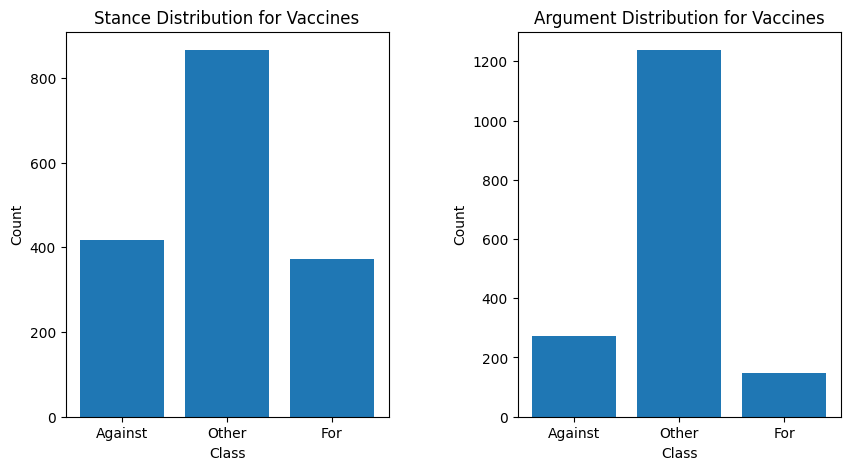

In [ ]:
# Count the number of samples for each class and for both stance and argument labels
stance_counts = train_df[f'{CLASS_NAME}_stance'].value_counts()
arg_counts = train_df[f'{CLASS_NAME}_argument'].value_counts()

# Create a figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create bar plots for stance and argument distributions
ax1.bar(stance_counts.index, stance_counts.values)
ax2.bar(arg_counts.index, arg_counts.values)

# Set the x-axis and y-axis labels for both subplots
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks([0, 1, 2])
ax1.set_xticklabels(['Against', 'Other', 'For'])
ax1.set_title(f'Stance Distribution for {CLASS_NAME.capitalize()}')

ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks([0, 1, 2])
ax2.set_xticklabels(['Against', 'Other', 'For'])
ax2.set_title(f'Argument Distribution for {CLASS_NAME.capitalize()}')

# Adjust the layout of the subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

In [ ]:
train_df, valid_df = train_test_split(train_df, stratify=train_df[f"{CLASS_NAME}_stance"], test_size=0.2, random_state=42)

print(f'Shape of train data: {train_df.shape}')
print(f'Shape of valid data: {valid_df.shape}')

Shape of train data: (1325, 3)
Shape of valid data: (332, 3)


In [ ]:
stance_class_counts = train_df[f'{CLASS_NAME}_stance'].value_counts()
stance_class_counts = [stance_class_counts[0], stance_class_counts[1], stance_class_counts[2]]
stance_class_weights = torch.tensor([1.0/count for count in stance_class_counts], dtype=torch.float)
stance_class_weights

tensor([0.0030, 0.0014, 0.0034])

In [ ]:
argument_class_counts = train_df[f'{CLASS_NAME}_argument'].value_counts()
argument_class_counts = [argument_class_counts[0], argument_class_counts[1], argument_class_counts[2]]
argument_class_weights = torch.tensor([1.0/count for count in argument_class_counts],  dtype=torch.float)
argument_class_weights

tensor([0.0047, 0.0010, 0.0080])

### Tokenization, create Datasets and Dataloaders


In [ ]:
tokenizer = BertTokenizer.from_pretrained(config['model_name'])

In [ ]:
topic = {
    "quarantine": "The introduction and enforcement of quarantine is good for society",
    "vaccines": "Vaccination is good for society",
    "masks": "Wearing masks is good for society"
}
PROMPT = f"What does the author think about the topic «{topic[CLASS_NAME]}»? [SEP] "

In [ ]:
example = train_df["text"][19]

tokenized_text = tokenizer(
    example,
    padding='max_length',
    max_length = 40,
    truncation=True,
    return_tensors="pt",
    is_split_into_words=True
)

print(example)
print(tokenized_text['input_ids'][0])
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))

Well, like the story of those who didn't want to wear a mask, and they're gonna force everyone to wear it.
tensor([ 101, 2092, 1010, 2066, 1996, 2466, 1997, 2216, 2040, 2134, 1005, 1056,
        2215, 2000, 4929, 1037, 7308, 1010, 1998, 2027, 1005, 2128, 6069, 2486,
        3071, 2000, 4929, 2009, 1012,  102,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
['[CLS]', 'well', ',', 'like', 'the', 'story', 'of', 'those', 'who', 'didn', "'", 't', 'want', 'to', 'wear', 'a', 'mask', ',', 'and', 'they', "'", 're', 'gonna', 'force', 'everyone', 'to', 'wear', 'it', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
example = PROMPT + train_df["text"][19]

tokenized_text = tokenizer(
    example,
    padding='max_length',
    max_length = 40,
    truncation=True,
    return_tensors="pt",
    is_split_into_words=True
)

print(example)
print(tokenized_text['input_ids'][0])
print(tokenizer.convert_ids_to_tokens(tokenized_text['input_ids'][0]))

What does the author think about the topic «Vaccination is good for society»? [SEP] Well, like the story of those who didn't want to wear a mask, and they're gonna force everyone to wear it.
tensor([  101,  2054,  2515,  1996,  3166,  2228,  2055,  1996,  8476,  1077,
        12436, 14693,  9323,  2003,  2204,  2005,  2554,  1090,  1029,   102,
         2092,  1010,  2066,  1996,  2466,  1997,  2216,  2040,  2134,  1005,
         1056,  2215,  2000,  4929,  1037,  7308,  1010,  1998,  2027,   102])
['[CLS]', 'what', 'does', 'the', 'author', 'think', 'about', 'the', 'topic', '«', 'va', '##cci', '##nation', 'is', 'good', 'for', 'society', '»', '?', '[SEP]', 'well', ',', 'like', 'the', 'story', 'of', 'those', 'who', 'didn', "'", 't', 'want', 'to', 'wear', 'a', 'mask', ',', 'and', 'they', '[SEP]']


In [ ]:
class MyDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer: BertTokenizer, max_length: int):

        texts = df['text'].values.tolist()
        texts = [PROMPT + text for text in texts]

        self.tokenized_texts = [
            tokenizer(
                text,
                add_special_tokens=True,
                max_length=max_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt',
                return_token_type_ids = False,
                return_attention_mask = True,
                verbose = True
            )
            for text in texts
        ]

        self.arguments = df[f'{CLASS_NAME}_argument']
        self.stances = df[f'{CLASS_NAME}_stance']

    def __len__(self):
        return len(self.arguments)

    def __getitem__(self, idx):
        input_ids = self.tokenized_texts[idx]['input_ids'].squeeze()
        attention_mask = self.tokenized_texts[idx]['attention_mask'].squeeze()
        label_stance = self.stances.iloc[idx]
        label_argument = self.arguments.iloc[idx]
        return input_ids, attention_mask, label_stance, label_argument

In [ ]:
train_dataset = MyDataset(train_df, tokenizer, config['max_length'])
valid_dataset = MyDataset(valid_df, tokenizer, config['max_length'])

train_loader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['eval_batch_size'], shuffle=True)

### Create model

In [ ]:
class MyModel(nn.Module):
    def __init__(self, bert_name):
        super(MyModel, self).__init__()
        self.num_labels = 3

        self.bert = BertModel.from_pretrained(bert_name)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.linear1 = nn.Linear(
            self.bert.config.hidden_size,
            self.num_labels
        )
        self.linear2 = nn.Linear(
            self.bert.config.hidden_size,
            self.num_labels
        )


    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = bert_output[1]
        pooled_output = self.dropout(pooled_output)
        logits_stance = self.linear1(pooled_output)
        logits_argument = self.linear2(pooled_output)

        return logits_stance, logits_argument

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [ ]:
model = MyModel(config['model_name'])
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

### Train and test model

In [ ]:
stance_loss_func = nn.CrossEntropyLoss(weight=stance_class_weights.to(device), reduction='mean')
argument_loss_func = nn.CrossEntropyLoss(weight=argument_class_weights.to(device), reduction='mean')

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    eps=config['epsilon'],
    weight_decay=config['weight_decay']
)

In [ ]:
total_steps = len(train_loader) * config['num_epoch']

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config['warmup_steps'],
    num_training_steps=total_steps,
)

In [ ]:
wandb.init(
    project='Argument Mining',
    entity="nickcalmykow281",
    name=f'fine-tune_{config["model_name"]}{config["num_expiriment"]}',
    config={
        'learning_rate': config['learning_rate'],
        'epochs': config['num_epoch'],
        'batch_size': config['train_batch_size'],
        'max_seq_length': config['max_length'],
    }
)

In [ ]:
def format_time(seconds: float) -> str:
    # Format time from seconds to hh:mm:ss format
    return str(datetime.timedelta(seconds=seconds))

In [ ]:
def f1_macro(logits_stance, logits_argument, labels_stance, labels_argument):
    # Compute the predictions for stance and argument
    probabilities_stance = torch.nn.functional.softmax(logits_stance, dim=1)
    pred_stance = torch.argmax(probabilities_stance, dim=1)
    probabilities_argument = torch.nn.functional.softmax(logits_argument, dim=1)
    pred_argument = torch.argmax(probabilities_argument, dim=1)

    # Compute the F1 macro score for stance and argument
    stance_f1 = f1_score(labels_stance.cpu(), pred_stance.cpu(), average='macro')
    argument_f1 = f1_score(labels_argument.cpu(), pred_argument.cpu(), average='macro')

    return {'stance_f1_macro': stance_f1, 'argument_f1_macro': argument_f1}

In [ ]:
best_metrics = 0
total_t0 = time.perf_counter()

for epoch in range(1, config['num_epoch'] + 1):

    print(f'======== Epoch {epoch} / {config["num_epoch"]} ========')
    print('Training...')

    t0 = time.perf_counter()
    total_train_loss = 0
    model.train()

    for step, train_batch in enumerate(train_loader):

        if step % 20 == 0 and not step == 0:
            elapsed = format_time(time.perf_counter() - t0)
            print(f'Batch {step} of {len(train_loader)}. Elapsed: {elapsed}.')
            wandb.log({'learning_rate': scheduler.get_last_lr()[0]})

        input_ids = train_batch[0].to(device)
        attention_mask = train_batch[1].to(device)
        stance_label = train_batch[2].to(device).long()
        argument_label = train_batch[3].to(device).long()

        optimizer.zero_grad()

        logits_stance, logits_argument = model(input_ids, attention_mask)

        loss_stance = stance_loss_func(logits_stance.view(-1, 3), stance_label)
        loss_argument = argument_loss_func(logits_argument.view(-1, 3), argument_label)
        loss = loss_stance + loss_argument

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()

        wandb.log({'train_loss': loss})

    avg_train_loss = total_train_loss/ len(train_loader)

    training_time = format_time(time.perf_counter() - t0)

    print(f'Average training loss: {avg_train_loss:.3f}')
    print(f'Training epcoh took: {training_time}')

    # Validation

    print('Running Validation...')

    t0 = time.perf_counter()
    total_eval_loss = 0
    model.eval()

    stance_f1, argument_f1 = 0, 0

    for valid_batch in valid_loader:

        input_ids = valid_batch[0].to(device)
        attention_mask = valid_batch[1].to(device)
        stance_label = valid_batch[2].to(device).long()
        argument_label = valid_batch[3].to(device).long()

        with torch.no_grad():
            logits_stance, logits_argument = model(input_ids, attention_mask)

        loss_stance = stance_loss_func(logits_stance.view(-1, 3), stance_label)
        loss_argument = argument_loss_func(logits_argument.view(-1, 3), argument_label)
        loss = loss_stance + loss_argument

        total_eval_loss += loss.item()

        # Compute the F1 macro score
        f1 = f1_macro(logits_stance, logits_argument, stance_label, argument_label)
        stance_f1 += f1['stance_f1_macro']
        argument_f1 += f1['argument_f1_macro']


    avg_val_loss = total_eval_loss / len(valid_loader)
    validation_time = format_time(time.perf_counter() - t0)

    stance_f1 /= len(valid_loader)
    argument_f1 /= len(valid_loader)

    if best_metrics < stance_f1 + argument_f1:
        best_metrics = stance_f1 + argument_f1
        torch.save(model.state_dict(), f"best_model_{CLASS_NAME}.pth")

    print("VALID METRICS:")
    print(f"Stance F1: {stance_f1}")
    print(f"Argument F1: {argument_f1}")
    print(f' Validation Loss: {avg_val_loss:.3f}')
    print(f' Validation took: {validation_time}')

    wandb.log({
        'epoch': epoch,
        'time': training_time + validation_time,
        'avg_train_loss': avg_train_loss,
        'avg_valid_loss': avg_val_loss,
        'valid_stance_f1': stance_f1,
        'valid_argument_f1': argument_f1,
    })

======== Epoch 1 / 10 ========
Training...
Batch 20 of 166. Elapsed: 0:00:02.678177.
Batch 40 of 166. Elapsed: 0:00:05.349959.
Batch 60 of 166. Elapsed: 0:00:08.036030.
Batch 80 of 166. Elapsed: 0:00:10.725464.
Batch 100 of 166. Elapsed: 0:00:13.401145.
Batch 120 of 166. Elapsed: 0:00:16.079082.
Batch 140 of 166. Elapsed: 0:00:18.748613.
Batch 160 of 166. Elapsed: 0:00:21.421162.
Average training loss: 2.202
Training epcoh took: 0:00:22.193787
Running Validation...
VALID METRICS:
Stance F1: 0.3870542596733075
Argument F1: 0.44654657511800366
 Validation Loss: 2.141
 Validation took: 0:00:01.731111
======== Epoch 2 / 10 ========
Training...
Batch 20 of 166. Elapsed: 0:00:02.672426.
Batch 40 of 166. Elapsed: 0:00:05.340259.
Batch 60 of 166. Elapsed: 0:00:08.014829.
Batch 80 of 166. Elapsed: 0:00:10.686510.
Batch 100 of 166. Elapsed: 0:00:13.363068.
Batch 120 of 166. Elapsed: 0:00:16.033110.
Batch 140 of 166. Elapsed: 0:00:18.708052.
Batch 160 of 166. Elapsed: 0:00:21.391622.
Average trai

In [ ]:
model = MyModel(config['model_name'])
model.load_state_dict(torch.load(f"best_model_{CLASS_NAME}.pth"))
model.eval()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
def predictor(text) -> tuple[int, int]:
    text = text.replace("[USER],", "")
    text = ' '.join(text.split(' '))

    text = PROMPT + text

    tokenized = tokenizer(
        text,
        add_special_tokens=True,
        max_length=config["max_length"],
        truncation=True,
        padding='max_length',
        return_tensors='pt',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
    )

    with torch.no_grad():
        logits_stance, logits_argument = model(tokenized['input_ids'], tokenized["attention_mask"])

    probabilities_stance = torch.nn.functional.softmax(logits_stance, dim=1)
    pred_stance = torch.argmax(probabilities_stance, dim=1)
    probabilities_argument = torch.nn.functional.softmax(logits_argument, dim=1)
    pred_argument = torch.argmax(probabilities_argument, dim=1)

    return pred_stance.item(), pred_argument.item()


In [ ]:
predictor('[USER], do not mislead people, influenza has a lethality of about one percent, this rubbish is about four, plus there are no drugs and vaccines, the spread is much faster.')

(1, 1)

In [ ]:
test_df = pd.read_csv('result.tsv', sep='\t')
test_df.head(5)

In [ ]:
for i in range(len(test_df)):
    if test_df[f"{CLASS_NAME}_stance"][i] != -1:
        stance, argument = predictor(test_df["text"][i])

        test_df.loc[i, f"{CLASS_NAME}_stance"] = stance
        test_df.loc[i, f"{CLASS_NAME}_argument"] = argument

In [ ]:
test_df[test_df[f"{CLASS_NAME}_stance"].isna()]

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument


In [ ]:
test_df.to_csv('result.tsv', sep="\t", index=False)